## Considerations

Dataset extracted from https://snap.stanford.edu/data/amazon0302.html
- Amazon network https://snap.stanford.edu/data/amazon0302.html
- Metadata https://snap.stanford.edu/data/amazon-meta.html

## Importings

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import time
import itertools
import warnings
import pickle

warnings.filterwarnings('ignore')

## Dataset

### Metadata

Treating metadata and organizing into a pandas dataframe

In [ ]:
# # read all lines of the meta data into content list
# with open('amazon-meta.txt', encoding='utf8') as f:
#     content = f.readlines()

In [ ]:
# # remove the beginning and trailing white spaces
# content = [x.strip() for x in content]

In [ ]:
# # Write extracted information to testfile.txt in a format of ',' demilited files.
# # The columns are Id, title, group, categories, totalreviews, avgrating.
# # The code stores all extracted information about a product into previoulines,
# # and write the content into file only when all information are available. Hence,
# # if review information for a product is not available, the product won't appear
# # in the final file.
# file = open("testfile.txt","w", encoding='utf8')
# previouslines = ['Id', 'title', 'group', 'categories', 'totalreviews', 'avgrating']
# for line in content:
#     lines = line.split(':')
#     if lines[0] == "Id":
#         if (len(previouslines) == 6):
#             for component in previouslines[0:5]:
#                 file.write(component)
#                 file.write(',')
#             file.write(previouslines[5])
#             file.write("\n")
#         previouslines = []
#         previouslines.append(lines[1].strip())
        
#     if lines[0] == "title":
#         title = ':'.join(lines[1:]).strip().replace(',', ' ').replace('\n', ' ').strip()
#         previouslines.append(title)
       
#     if lines[0] == "group":
#         previouslines.append(lines[1].strip())

#     if lines[0] == "categories":
#         previouslines.append(lines[1].strip())
    
#     if lines[0] == "reviews" and lines[1].strip() == "total":
#         previouslines.append(lines[2].split(' ')[1])
#         previouslines.append(lines[4].strip())
# file.close()

In [ ]:
# metadata
desc = pd.read_csv('testfile.txt')

In [ ]:
desc.head()

,Id,title,group,categories,totalreviews,avgrating
0,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,2,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,2,0,0.0


#### EDA

In [ ]:
desc.nunique()

Id              542683
title           499796
group               10
categories          90
totalreviews       958
avgrating           10
dtype: int64

In [ ]:
desc['group'].value_counts()

Book            393561
Music           103143
Video            26131
DVD              19828
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: group, dtype: int64

In [ ]:
desc = desc[desc['group'].isin(['Book', 'Music', 'DVD', 'Video'])]

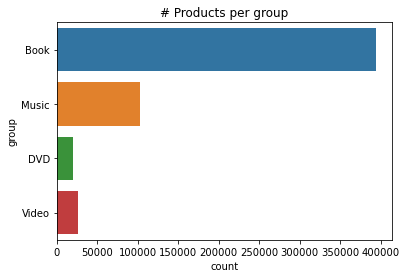

In [ ]:
plt.title('# Products per group')
sns.countplot(data=desc, y='group');

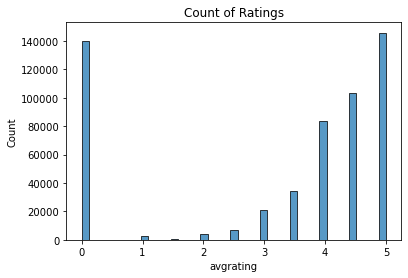

In [ ]:
plt.title('Count of Ratings')
sns.histplot(data=desc, x='avgrating');

<AxesSubplot:title={'center':'Average rating per group'}, xlabel='group', ylabel='avgrating'>

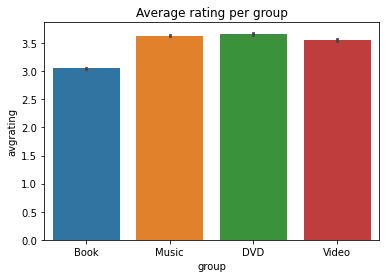

In [ ]:
plt.title('Average rating per group')
sns.barplot(data=desc, x='group', y='avgrating')

In [ ]:
desc['categories'].nunique()

90

In [ ]:
a = [''] * 90

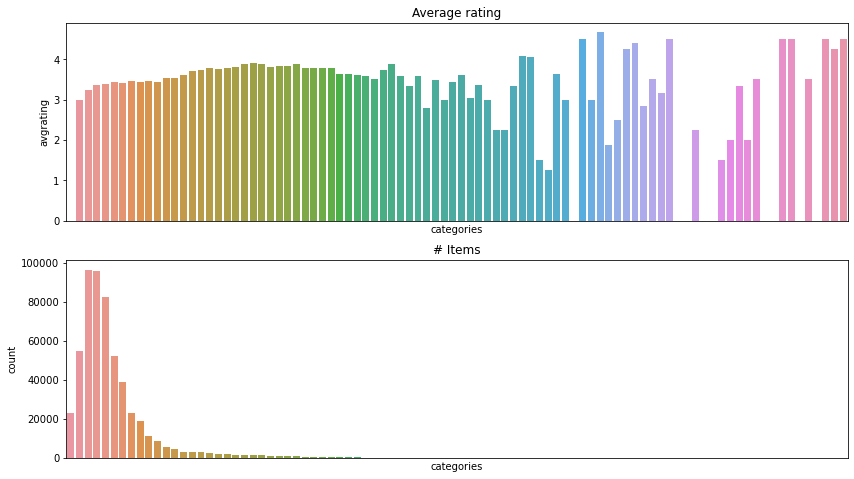

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)


sns.barplot(data=desc, x='categories', y='avgrating', ci=None, ax=ax[0])
sns.countplot(data=desc, x='categories', ax=ax[1])

ax[1].set_xticks([])

ax[0].set_title('Average rating')
ax[1].set_title('# Items')
plt.show()

In [ ]:
desc[['totalreviews', 'avgrating']].corr()

,totalreviews,avgrating
totalreviews,1.000000,0.093652
avgrating,0.093652,1.000000


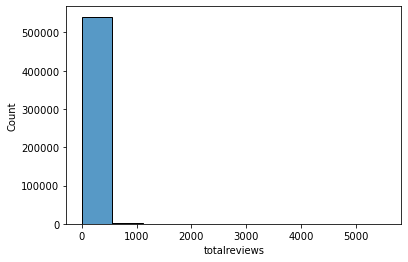

In [ ]:
sns.histplot(data=desc, x='totalreviews', bins=10);

<AxesSubplot:>

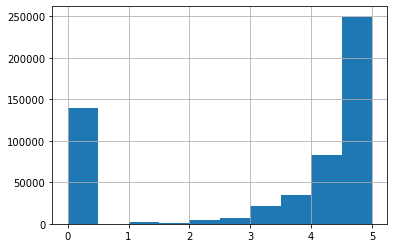

In [ ]:
desc['avgrating'].hist()

### Network

Reading dataframe and merging with metadata information

In [ ]:
df = pd.read_csv('Amazon0302.txt', skiprows=4, header=None, sep='\t', names=['from', 'to'])

In [ ]:
# Join the link data with the meta data. The joined data contains the description for
# from node product as well as to node product.
df = (
    df
    .merge(desc, left_on=['from'], right_on=['Id'], suffixes=['.1', '.from'])
    .merge(desc, left_on=['to'], right_on=['Id'], suffixes=['.from', '.to'])
)

In [ ]:
df.head(3)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
2,16,4,16,War at Sea: A Naval History of World War II,Book,3,10,4.5,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


## EDA

Basic exploratory analysis

In [ ]:
print('Unique titles:', desc['title'].nunique())
print('Unique Categories:', desc['categories'].nunique())

Unique titles: 499776
Unique Categories: 90


In [ ]:
desc['group'].value_counts()

Book     393561
Music    103143
Video     26131
DVD       19828
Name: group, dtype: int64

In [ ]:
df.shape

(1207262, 14)

In [ ]:
df.head(3)

,from,to,Id.from,title.from,group.from,categories.from,totalreviews.from,avgrating.from,Id.to,title.to,group.to,categories.to,totalreviews.to,avgrating.to
0,1,2,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,2,Candlemas: Feast of Flames,Book,2,12,4.5
1,1,4,1,Patterns of Preaching: A Sermon Sampler,Book,2,2,5.0,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0
2,16,4,16,War at Sea: A Naval History of World War II,Book,3,10,4.5,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,5,1,4.0


## Creating graph

### Vertices

In [ ]:
# creating weight for edges
# avgrating performed better and indicates the strenght of higher ratings

df['avgrating'] = df['avgrating.from'] * df['avgrating.to']

In [ ]:
g = ig.Graph.DataFrame(df[['from', 'to', 'avgrating']], directed=False)

In [ ]:
g.summary()

'IGRAPH UN-- 259092 1207262 -- \n+ attr: name (v), avgrating (e)'

In [ ]:
g.vs.attribute_names()

['name']

In [ ]:
g_summary = pd.DataFrame({
    'degree': g.degree(),
    'transitivity': g.transitivity_local_undirected()
}) 

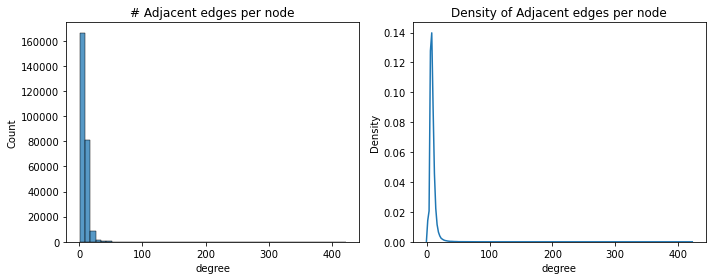

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('# Adjacent edges per node')
ax[1].set_title('Density of Adjacent edges per node')

sns.histplot(data=g_summary, x='degree', bins=50, ax=ax[0])
sns.kdeplot(data=g_summary, x='degree', ax=ax[1])
plt.tight_layout();

In [ ]:
(
    g_summary['degree'].
    value_counts(1).
    sort_index().
    cumsum().
    head(10)
)

1     0.010182
2     0.026689
3     0.042468
4     0.064004
5     0.092168
6     0.231636
7     0.387025
8     0.525555
9     0.641780
10    0.734349
Name: degree, dtype: float64

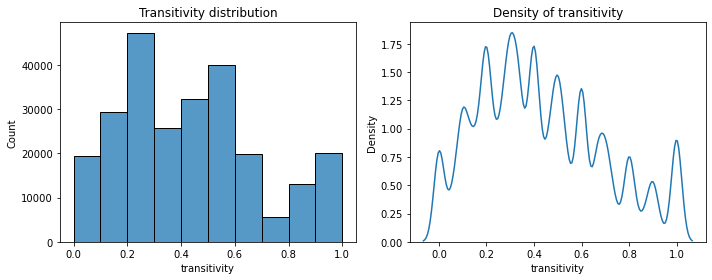

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('Transitivity distribution')
ax[1].set_title('Density of transitivity')

sns.histplot(data=g_summary, x='transitivity', bins=10, ax=ax[0])
sns.kdeplot(data=g_summary, x='transitivity', ax=ax[1])
plt.tight_layout();

## Clustering

Selecting only the highest connected network

In [ ]:
cc = g.clusters(mode='weak')
print('# connected components', len(cc))

# connected components 22


In [ ]:
cc = np.array(
    sorted(cc, key=len, reverse=True), dtype='object'
)

In [ ]:
print('Top 5 connected networks')
[len(cc[i]) for i in range(5)]

Top 5 connected networks


[258958, 22, 15, 13, 11]

In [ ]:
g = g.subgraph(cc[0])

In [ ]:
g.summary()

'IGRAPH UN-- 258958 1206732 -- \n+ attr: name (v), avgrating (e)'

### Leiden

In [ ]:
start = time.time()
coms_leid_raw = g.community_leiden()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_leid_raw.modularity)

Time elapsed: 4.323301076889038
Modularity: 0.41210093782920315


In [ ]:
start = time.time()
coms_leid_w = g.community_leiden(weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_leid_w.modularity)

Time elapsed: 3.2285406589508057
Modularity: 0.8016888158036107


### Louvain

In [ ]:
start = time.time()
coms_louv_raw = g.community_multilevel()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_louv_raw.modularity)

Time elapsed: 6.170644044876099
Modularity: 0.9155484245803982


In [ ]:
start = time.time()
coms_louv_w = g.community_multilevel(weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_louv_w.modularity)

Time elapsed: 6.315048933029175
Modularity: 0.9302381990619313


### Infomap

In [ ]:
start = time.time()
coms_info_raw = g.community_infomap()
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_info_raw.modularity)

Time elapsed: 926.2333419322968
Modularity: 0.2387077116264778


In [ ]:
start = time.time()
coms_info_w = g.community_infomap(edge_weights=g.es['avgrating'])
print('Time elapsed:', time.time() - start)
print('Modularity:', coms_info_w.modularity)

Time elapsed: 556.3165123462677
Modularity: 0.305513656724806


### Save community

In [ ]:
coms = {
    'leiden_raw': coms_leid_raw,
    'leiden_weighted': coms_leid_w,
    'louvain_raw': coms_louv_raw,
    'louvain_weighted': coms_louv_w,
    'infomap_raw': coms_info_raw,
    'infomap_weighted': coms_info_w
}

In [ ]:
# with open('coms.pkl', 'wb') as f:
#     pickle.dump(coms, f)

with open('coms.pkl', 'rb') as f:
    coms = pickle.load(f)

## Evaluating clusters

In [ ]:
df_coms = pd.DataFrame({
    'Id': g.vs()['name'],
    'degree': g.degree(),
    'transitivity': g.transitivity_local_undirected()
})

names = ['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']

In [ ]:
for i, j in coms.items():
    df_coms[i] = j.membership

hubdom = {}
for i in names:
  df = df_coms[['Id',f'{i}', 'degree', 'transitivity']]
  df['count'] = df.groupby(f'{i}')[f'{i}'].transform('size')

  df['degree_value'] = df['degree'] / df['count']

  df = df.loc[df.groupby(f'{i}')['degree_value'].idxmax()]
  df['hubdom_value'] = (df['degree_value']-df['degree_value'].min())/(df['degree_value'].max()-df['degree_value'].min())

  hubdom.update({f'{i}-hub':df})

In [ ]:
for k,v in hubdom.items():
  plt.figure(k)
  sns.scatterplot(data=hubdom[f'{k}'], x="transitivity", y="hubdom_value", label=k)

In [ ]:
df_coms

,Id,leiden_raw,leiden_weighted,louvain_raw,louvain_weighted,infomap_raw,infomap_weighted
0,1.0,0,0,0,0,0,0
1,2.0,1,0,0,0,0,0
2,3.0,2,1,1,1,1,1
3,4.0,3,2,1,2,2,2
4,5.0,4,3,2,3,3,3
...,...,...,...,...,...,...,...
258953,262106.0,113840,92376,108,72697,82427,119042
258954,262107.0,113841,92367,108,4927,82426,119039
258955,262108.0,113842,92367,108,4927,82426,119039
258956,262109.0,113843,92367,108,4927,82426,119039


In [ ]:
df_coms.nunique()

Id                  258958
leiden_raw          113844
leiden_weighted      92377
louvain_raw            198
louvain_weighted     72698
infomap_raw          82429
infomap_weighted    119043
dtype: int64

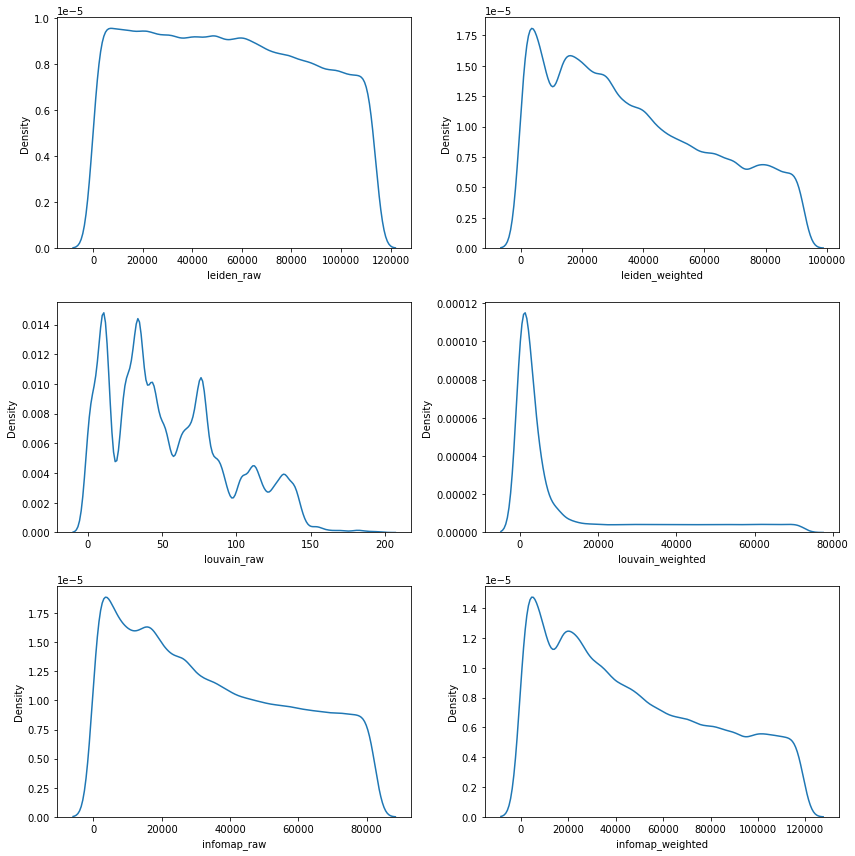

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))

sns.kdeplot(data=df_coms, x='leiden_raw', ax=ax[0, 0])
sns.kdeplot(data=df_coms, x='leiden_weighted', ax=ax[0, 1])
sns.kdeplot(data=df_coms, x='louvain_raw', ax=ax[1, 0])
sns.kdeplot(data=df_coms, x='louvain_weighted', ax=ax[1, 1])
sns.kdeplot(data=df_coms, x='infomap_raw', ax=ax[2, 0])
sns.kdeplot(data=df_coms, x='infomap_weighted', ax=ax[2, 1])

plt.tight_layout();

In [ ]:
df_coms_summary = pd.DataFrame({
    'modularity': [i.modularity for i in coms.values()],
    'communities': [len(set(i.membership)) for i in coms.values()]
}, index=names).sort_values('modularity')

In [ ]:
df_coms_summary

,modularity,communities
infomap_raw,0.238708,82429
infomap_weighted,0.305514,119043
leiden_raw,0.412101,113844
leiden_weighted,0.801689,92377
louvain_raw,0.915548,198
louvain_weighted,0.930238,72698


Louvain weighted presented the highest modularity and showed 72698 communities

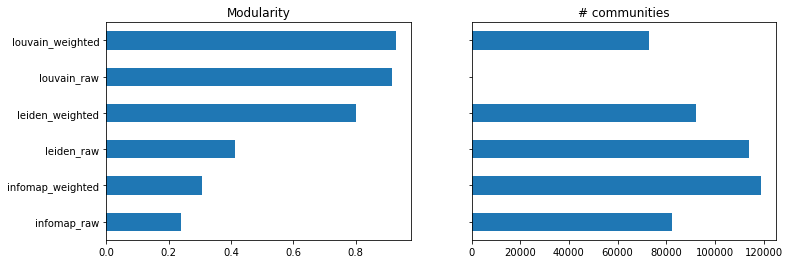

In [ ]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

df_coms_summary['modularity'].plot.barh(title='Modularity', ax=ax[0])
df_coms_summary['communities'].plot.barh(title='# communities', ax=ax[1]);

We can compare the nmi and adjusted rand between the communities created

In [ ]:
comb_names_1 = []
comb_names_2 = []
comb_nmi = []
comb_rand = []

for n, c in zip(itertools.combinations(coms.keys(), 2), itertools.combinations(coms.values(), 2)):
    comb_names.append(f'{n[0]} & {n[1]}')
    comb_nmi.append(ig.compare_communities(c[0], c[1], method='nmi'))
    comb_rand.append(ig.compare_communities(c[0], c[1], method='adjusted_rand'))

In [ ]:
df_comb = pd.DataFrame({
    'algorithm_1': comb_names_1,
    'algorithm_2': comb_names_2,
    'nmi': comb_nmi,
    'adjusted_rand': comb_rand
}, index=comb_names_1).sort_values('nmi')

df_comb

,nmi,adjusted_rand
louvain_raw & infomap_weighted,0.543463,0.001682
louvain_raw & infomap_raw,0.552436,0.001810
leiden_raw & louvain_raw,0.558492,0.000931
leiden_weighted & louvain_raw,0.575382,0.003226
louvain_raw & louvain_weighted,0.586484,0.297765
louvain_weighted & infomap_raw,0.710586,0.002263
leiden_raw & louvain_weighted,0.723267,0.001205
louvain_weighted & infomap_weighted,0.758176,0.004159
leiden_weighted & louvain_weighted,0.794863,0.008179
leiden_weighted & infomap_raw,0.903192,0.151666


In [ ]:
resultnmi = df_comb.pivot(index='algorithm_1', columns='algorithm_2', values='nmi')

print(resultnmi)

resultnmi = resultnmi[['leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']]
resultnmi = resultnmi.reindex(['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw'])

ax = sns.heatmap(resultnmi, annot=True, fmt="g", cmap='Blues')
ax.set(title='NMI Heatmap', xlabel='detection algorithms', ylabel='detection algorithms')

In [ ]:
resultrand = df_comb.pivot(index='algorithm_1', columns='algorithm_2', values='adjusted_rand').round(decimals=2)

print(resultrand)

resultrand = resultrand[['leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw', 'infomap_weighted']]
resultrand = resultrand.reindex(['leiden_raw', 'leiden_weighted', 'louvain_raw', 'louvain_weighted', 'infomap_raw'])

ax = sns.heatmap(resultrand, annot=True, fmt="g", cmap='Blues')
ax.set(title='Adjusted Rand Heatmap', xlabel='detection algorithms', ylabel='detection algorithms')

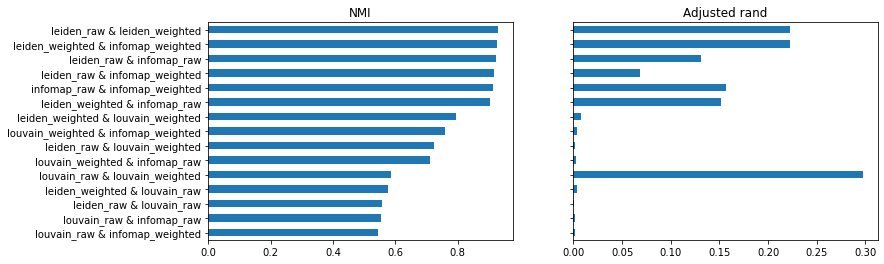

In [ ]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
df_comb['nmi'].plot.barh(title='NMI', ax=ax[0])
df_comb['adjusted_rand'].plot.barh(title='Adjusted rand', ax=ax[1]);

## Louvaing weighted

Selecting the highest community of louvain weighted

In [ ]:
g_giant_louv_w = coms['louvain_weighted'].giant()

In [ ]:
df_giant_louv_w = pd.DataFrame({
    'Id': g_giant_louv_w.vs['name'],
    'degree': g_giant_louv_w.degree(),
    'betweenness': g_giant_louv_w.betweenness(),
    'clustering_coefficient': g_giant_louv_w.transitivity_local_undirected()
})

In [ ]:
df_giant_louv_w['Id'] = df_giant_louv_w['Id'].astype(int)

In [ ]:
df_giant_louv_w = df_giant_louv_w.merge(desc, on='Id')

In [ ]:
df_giant_louv_w.shape

(9443, 9)

We can check the products of the highest community 

In [ ]:
df_giant_louv_w[
    (df_giant_louv_w['betweenness'] > np.quantile(df_giant_louv_w['betweenness'], 0.95)) &
    (df_giant_louv_w['degree'] > np.quantile(df_giant_louv_w['degree'], 0.95))
]

,Id,degree,betweenness,clustering_coefficient,title,group,categories,totalreviews,avgrating
0,33,109,4.624166e+06,0.012232,Double Jeopardy (T*Witches 6),Book,6,4,5.0
1,94,41,5.495148e+05,0.068293,The American Heritage Dictionary of Idioms,Book,4,15,4.0
2,96,24,3.224198e+05,0.110672,Becoming a Contagious Christian,Book,3,21,4.0
3,132,17,2.586935e+05,0.044118,Iyanla Live! : Back to Basics (Iyanla Live!),Book,10,1,5.0
5,151,65,2.833857e+06,0.055812,Laurel & Hardy - Flying Deuces/Utopia,DVD,16,13,3.0
...,...,...,...,...,...,...,...,...,...
4010,32307,19,1.187560e+05,0.175000,The Source of My Strength (EZ Lesson Plan (Boo...,Book,1,10,5.0
4096,33220,23,1.027311e+05,0.180952,Joven Para Morir,Music,14,1,3.0
4206,34536,17,1.209194e+05,0.180952,Big N Round,Music,2,2,4.0
4634,40706,16,2.539695e+05,0.054945,The Story of Art,Book,2,18,5.0


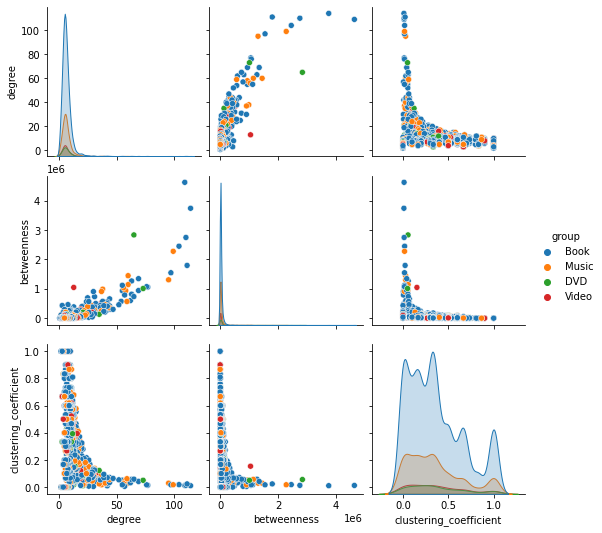

In [ ]:
sns.pairplot(data=df_giant_louv_w[['degree', 'betweenness', 'clustering_coefficient', 'group']], hue='group')

## Visualization

In [ ]:
# considering the top 2nd most connected network
g_sub = g.subgraph(cc[1])

In [ ]:
layout_fr = g_sub.layout('fr')

visual_style = {
    #Define style from network plotting
    "vertex_size": 5,
    "vertex_color": 'orange',
    "edge_arrow_size": 0.5,
    "edge_width":0.5,
    "vertex_label": None,
    "layout": layout_fr,
    "bbox": (600, 600),
    "edge_width": 1
}

ig.plot(g_sub, **visual_style)